In [91]:
import casadi as ca
import numpy as np
import math

In [92]:
roll = ca.SX.sym('roll')
pitch = ca.SX.sym('pitch')
yaw = ca.SX.sym('yaw')

r_roll = ca.SX_eye(3)
r_roll[1:,1:] = np.array([[ca.cos(roll), -ca.sin(roll)],
                 [ca.sin(roll), ca.cos(roll)]])
r_pitch = ca.SX_eye(3)
r_pitch[[0,2],[0,2]] = np.array([[ca.cos(pitch), ca.sin(pitch)],
                 [-ca.sin(pitch), ca.cos(pitch)]])
r_yaw = ca.SX_eye(3)
r_yaw[:2,:2] = np.array([[ca.cos(yaw), -ca.sin(yaw)],
                 [ca.sin(yaw), ca.cos(yaw)]])

print("ROLL", r_roll)
print("PITCH", r_pitch)
print("YAW", r_yaw)

R = (r_yaw @ r_pitch @ r_roll)
print("Y-P-R")
for i in range(0,3):
    for j in range(0,3):
        print(R[i, j],end=' , ')
    print()

print(ca.Function('rot', [yaw, pitch], [r_yaw @ r_pitch])(11*math.pi/180, 68*math.pi/180))


ROLL 
[[1, 00, 00], 
 [00, cos(roll), (-sin(roll))], 
 [00, sin(roll), cos(roll)]]
PITCH 
[[cos(pitch), 00, sin(pitch)], 
 [00, 1, 00], 
 [(-sin(pitch)), 00, cos(pitch)]]
YAW 
[[cos(yaw), (-sin(yaw)), 00], 
 [sin(yaw), cos(yaw), 00], 
 [00, 00, 1]]
Y-P-R
(cos(yaw)*cos(pitch)) , (((cos(yaw)*sin(pitch))*sin(roll))-(sin(yaw)*cos(roll))) , ((sin(yaw)*sin(roll))+((cos(yaw)*sin(pitch))*cos(roll))) , 
(sin(yaw)*cos(pitch)) , ((cos(yaw)*cos(roll))+((sin(yaw)*sin(pitch))*sin(roll))) , (((sin(yaw)*sin(pitch))*cos(roll))-(cos(yaw)*sin(roll))) , 
(-sin(pitch)) , (cos(pitch)*sin(roll)) , (cos(pitch)*cos(roll)) , 

[[0.367724, -0.190809, 0.910149], 
 [0.0714783, 0.981627, 0.176915], 
 [-0.927184, 00, 0.374607]]


In [93]:
## For magnetometer measurement correction
print("Correction : Intrinsic P-R")
R = r_pitch @ r_roll
for i in range(0,3):
    for j in range(0,3):
        print(R[i, j],end=' , ')
    print()

Correction : Intrinsic P-R
cos(pitch) , (sin(pitch)*sin(roll)) , (sin(pitch)*cos(roll)) , 
00 , cos(roll) , (-sin(roll)) , 
(-sin(pitch)) , (cos(pitch)*sin(roll)) , (cos(pitch)*cos(roll)) , 


## Complementary Filter Derivation
For our complementary filter we use an intrinsic Y-P-R sequence, meaning from the inertial frame we first rotate by a yaw angle $\psi$ then by a pitch angles $\theta$ then by a roll angle $\phi$ giving our rotation from inertial to body as $${}^{I}R_{B}=R_{\psi}R_{\theta}R_{\phi}$$
$$R=\begin{bmatrix}
\cos{\psi} & -\sin{\psi} & 0 \\
\sin{\psi} & \cos{\psi} & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\cos{\theta} & 0 & \sin{\theta} \\
0 & 1 & 0 \\
-\sin{\theta} & 0 & \cos{\theta} \\
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos{\phi} & -\sin{\phi} \\
0 & \sin{\phi} & \cos{\phi}
\end{bmatrix}$$

This rotation can translate a vector expressed in the body frame to the inertial frame via:
$$\textbf{v}_{I}={}^{I}R_{B}\textbf{v}_{B}$$

Likewise, we can also transform a vector expressed in the inertial frame to the body frame via:
$$\textbf{v}_{B}=({}^{I}R_{B})^{T}\textbf{v}_{I}$$

We have ${}^{I}R_{B}=R_{\psi}R_{\theta}R_{\phi}$ which we can expand to $({}^{I}R_{B})^{T}=R^{T}_{\phi}R^{T}_{\theta}R^{T}_{\psi}$ noting the change in the order.

### Accelerometer Derivation - Roll and Pitch
While our accelerometer measurements are in the body-frame, we know the gravitational vector in the (NED) inertial frame is
$$\textbf{a}_{I}=\begin{bmatrix}0 \\ 0 \\ -g\end{bmatrix}$$

We will solve the following equation to obtain our tilt angles $\phi$ and $\theta$
$$\begin{bmatrix}a_{x} \\ a_{y} \\ a_{z}\end{bmatrix}=({}^{I}R_{B})^{T}\begin{bmatrix}0 \\ 0 \\ -g\end{bmatrix}$$

Assuming no yaw ($\psi=0$), we know our tilt is defined as:
$$\begin{bmatrix}
a_{x} \\
a_{y} \\
a_{z} \\
\end{bmatrix}=
\begin{bmatrix}
\cos{\theta} & 0 & -\sin{\theta} \\
\sin{\phi}\sin{\theta} & \cos{\phi} & \sin{\phi}\cos{\theta} \\
\cos{\phi}\sin{\theta} & -\sin{\phi} & \cos{\phi}\cos{\theta} \\
\end{bmatrix}
\begin{bmatrix}
0 \\
0 \\
-g \\
\end{bmatrix}
$$

Expanding gives us these equations$$
\begin{align}
g\sin{\theta}&=a_{x} \\
-g\sin{\phi}\cos{\theta}&=a_{y} \\
-g\cos{\phi}\cos{\theta}&=a_{z}
\end{align}$$

We can divide the second row by the third row to get
$$\tan{\phi} = \frac{a_{y}}{a_{z}}$$
Because we are in the NED frame, $a_{z}$ will be negative between $\frac{\pi}{2}\leq\phi\leq\frac{\pi}{2}$ which means we need to negate $a_{z}$. We also then negate $a_{y}$ to keep the equation consistent.
$$\phi=atan2(-a_{y},-a_{z}), -\frac{\pi}{2}\leq\phi\leq\frac{\pi}{2}$$

For the pitch, we can square both sides of the second and third equations to get
$$g^{2}\sin^{2}{\phi}\cos^{2}{\theta}=a_{y}^{2}$$
$$g^{2}\cos^{2}{\phi}\cos^{2}{\theta}=a_{z}^{2}$$

We also square the first equation to get
$$g^{2}=\frac{a_{x}}{\sin{\theta}}$$

We can sum the first two squared equations, and then subsitute g from the other equation as follows
$$g^{2}\sin^{2}{\phi}\cos^{2}{\theta} + g^{2}\cos^{2}{\phi}\cos^{2}{\theta}=a_{z}^{2}+a_{y}^{2}$$
$$g^{2}\cos^{2}{\theta}=a_{z}^{2}+a_{y}^{2}$$
$$\frac{a_{x}^{2}\cos^{2}{\theta}}{\sin^{2}{\theta}}=a_{z}^{2}+a_{y}^{2}$$

Re-arranging and taking the square root of both sides gives us
$$\tan{\theta}=\frac{a_{x}}{\sqrt{a_{z}^{2}+a_{y}^{2}}}$$
$$\theta=\text{atan2}(a_{x},\sqrt{a_{z}^{2}+a_{y}^{2}}),-\pi\leq\theta\leq\pi$$

### Magnetometer Derivation
Again, we can re-use the roll/pitch rotation to transform our body-frame magnetometer reading into a 'yaw-only' frame with x and y axes aligned to the NED frame X-Y plane
$$\begin{align}
\begin{bmatrix}
m_{x,comp} \\
m_{y,comp} \\
m_{z,comp} \\
\end{bmatrix}&=
\begin{bmatrix}
\cos{\theta} & \sin{\theta}\sin{\phi} & \sin{\theta}\cos{\phi} \\
0 & \cos{\phi} & -\sin{\phi} \\
-\sin{\theta} & \cos{\theta}\sin{\phi} & \cos{\theta}\cos{\phi} \\
\end{bmatrix}
\begin{bmatrix}
m_{x} \\
m_{y} \\
m_{z} \\
\end{bmatrix} \\
&=\begin{bmatrix}
m_{x}\cos{\theta} + m_{y}\sin{\theta}\sin{\phi} + m_{z}\sin{\theta}\cos{\phi} \\
m_{y}\cos{\phi} -m_{z}\sin{\phi} \\
-m_{x}\sin{\theta} + m_{y}\cos{\theta}\sin{\phi} + m_{z}\cos{\theta}\cos{\phi} \\
\end{bmatrix}
\end{align}
$$
In our 'yaw-only' frame, and ignoring magnetic declination for now, we can relate the magnetic field vector to our (tilt-compensated) reading via
$$
B_{ref}=
\begin{bmatrix}
b_{x} \\
0 \\
b_{z}
\end{bmatrix}
= \begin{bmatrix}
\cos{\psi} & -\sin{\psi} & 0 \\
\sin{\psi} & \cos{\psi} & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
m_{x,comp} \\
m_{y,comp} \\
m_{z,comp} \\
\end{bmatrix}
$$
Now our $B_{ref}$ vector has x and z components only and hence we can use the second equation to compute yaw
$$\psi=\text{atan2}(-m_{y,comp},m_{x,comp})$$

The last step is to offset this yaw measurement by the magnetic declination for the current location.

In [94]:
roll = ca.SX.sym('roll')
pitch = ca.SX.sym('pitch')
yaw = ca.SX.sym('yaw')

r_roll = ca.SX_eye(3)
r_roll[1:,1:] = np.array([[ca.cos(roll), -ca.sin(roll)],
                 [ca.sin(roll), ca.cos(roll)]])
r_pitch = ca.SX_eye(3)
r_pitch[[0,2],[0,2]] = np.array([[ca.cos(pitch), ca.sin(pitch)],
                 [-ca.sin(pitch), ca.cos(pitch)]])
r_yaw = ca.SX_eye(3)
r_yaw[:2,:2] = np.array([[ca.cos(yaw), -ca.sin(yaw)],
                 [ca.sin(yaw), ca.cos(yaw)]])

print("ROLL", r_roll)
print("PITCH", r_pitch)
print("YAW", r_yaw)

for i in range(0,3):
    for j in range(0,3):
        print((r_roll.T @ r_pitch.T)[i, j], end=' , ')
    print()
print('--')
print(f"PITCH-ROLL")
for i in range(0,3):
    for j in range(0,3):
        print(( r_pitch @ r_roll)[i, j], end=' , ')
    print()

ROLL 
[[1, 00, 00], 
 [00, cos(roll), (-sin(roll))], 
 [00, sin(roll), cos(roll)]]
PITCH 
[[cos(pitch), 00, sin(pitch)], 
 [00, 1, 00], 
 [(-sin(pitch)), 00, cos(pitch)]]
YAW 
[[cos(yaw), (-sin(yaw)), 00], 
 [sin(yaw), cos(yaw), 00], 
 [00, 00, 1]]
cos(pitch) , 00 , (-sin(pitch)) , 
(sin(roll)*sin(pitch)) , cos(roll) , (sin(roll)*cos(pitch)) , 
(cos(roll)*sin(pitch)) , (-sin(roll)) , (cos(roll)*cos(pitch)) , 
--
PITCH-ROLL
cos(pitch) , (sin(pitch)*sin(roll)) , (sin(pitch)*cos(roll)) , 
00 , cos(roll) , (-sin(roll)) , 
(-sin(pitch)) , (cos(pitch)*sin(roll)) , (cos(pitch)*cos(roll)) , 


## Euler Rates from Gyroscope
Our gyroscope measures angular velocity in the body-fixed frame however, our state vector uses euler angles (and their derivatives, the euler rates) in sequentially rotated frames, so we need to transform each back. Our roll rate is actually in the same frame as the gyroscope (body-fixed frame) but the other two require rotations. The full equation:
$$\begin{align}\begin{bmatrix}
p \\ q \\ r
\end{bmatrix}
&=\begin{bmatrix} \dot{\phi} \\ 0 \\ 0 \end{bmatrix}
+ (R_{\phi})^{T}\begin{bmatrix}0 \\ \dot{\theta} \\ 0\end{bmatrix}
+ (R_{\theta}R_{\phi})^{T}\begin{bmatrix}0 \\ 0 \\ \dot{\psi} \end{bmatrix} \\
&= \begin{bmatrix}1 & 0 & -\sin{\theta} \\ 0 & \cos{\phi} & \sin{\phi}\cos{\theta} \\ 0 & -\sin{\phi} & \cos{\theta}\cos{\phi}\end{bmatrix}
\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi}
\end{bmatrix}
\end{align}
$$

$$
\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi}
\end{bmatrix} = \begin{bmatrix}
1 & \sin{\phi}\tan{\theta} & \cos{\phi}\tan{\theta} \\
0 & \cos{\phi} & -\sin{\phi} \\
0 & \frac{\sin{\phi}}{\cos{\theta}} & \frac{\cos{\phi}}{\cos{\theta}}
\end{bmatrix}
\begin{bmatrix} p \\ q \\ r
\end{bmatrix}
$$

In [95]:
droll = ca.SX.sym('droll')
dpitch = ca.SX.sym('dpitch')
dyaw = ca.SX.sym('dyaw')

pqr_mat = ca.vertcat(droll,0,0) + r_roll.T @ ca.vertcat(0,dpitch,0) + (r_pitch @ r_roll).T @ ca.vertcat(0,0,dyaw)

for i in range(0,3):
    print(f"{i}: {pqr_mat[i]}")

0: (droll-(sin(pitch)*dyaw))
1: ((cos(roll)*dpitch)+((cos(pitch)*sin(roll))*dyaw))
2: (((cos(pitch)*cos(roll))*dyaw)-(sin(roll)*dpitch))


In [96]:
pqr_factored = ca.vertcat(
    ca.horzcat(1, 0 , -ca.sin(pitch)),
    ca.horzcat(0, ca.cos(roll), ca.sin(roll)*ca.cos(pitch)),
    ca.horzcat(0, -ca.sin(roll), ca.cos(pitch)*ca.cos(roll)))

pqr_inv = ca.inv(pqr_factored)

for i in range(0,3):
    for j in range(0,3):
        print(pqr_inv[i,j], end=' ')
    print()

@1=cos(roll), @2=(cos(pitch)*cos(roll)), @3=(sin(roll)*cos(pitch)), @4=sin(roll), (((@1*@2)+(@3*@4))/((@1*@2)+(@3*@4))) @1=sin(roll), ((@1*sin(pitch))/((cos(roll)*(cos(pitch)*cos(roll)))+((sin(roll)*cos(pitch))*@1))) @1=cos(roll), ((@1*sin(pitch))/((@1*(cos(pitch)*cos(roll)))+((sin(roll)*cos(pitch))*sin(roll)))) 
00 @1=(cos(pitch)*cos(roll)), (@1/((cos(roll)*@1)+((sin(roll)*cos(pitch))*sin(roll)))) @1=(sin(roll)*cos(pitch)), (-(@1/((cos(roll)*(cos(pitch)*cos(roll)))+(@1*sin(roll))))) 
00 @1=sin(roll), (@1/((cos(roll)*(cos(pitch)*cos(roll)))+((sin(roll)*cos(pitch))*@1))) @1=cos(roll), (@1/((@1*(cos(pitch)*cos(roll)))+((sin(roll)*cos(pitch))*sin(roll)))) 


## Reconstruction of Complementary State from Simulated Sensor Readings

To summarise equations
$$\tan{\phi}=\frac{a_y}{a_z}$$
$$\tan{\theta}=\frac{a_x}{\sqrt{a_y^{2}+a_z^{2}}}$$

In [97]:
from matplotlib import pyplot as plt
import struct
import math

## Configs
#max_iter = 125
max_iter = None

def parse(frame, ctx):
    #print(f"pkt found {len(frame)} {frame[2]}")
    if frame[2]==0x01:
        roll, pitch, yaw = struct.unpack('<fff', frame[4:])
        ctx['roll'].append(roll)
        ctx['pitch'].append(pitch)
        ctx['yaw'].append(yaw)

    elif frame[2]==0x02:
        pos_x, pos_y, pos_z = struct.unpack('<fff', frame[4:])
        ctx['pos_x'].append(pos_x)
        ctx['pos_y'].append(pos_y)
        ctx['pos_z'].append(pos_z)

    elif frame[2]==0x03:
        vel_x, vel_y, vel_z = struct.unpack('<fff', frame[4:])
        ctx['vel_x'].append(vel_x)
        ctx['vel_y'].append(vel_y)
        ctx['vel_z'].append(vel_z)

    elif frame[2]==0x04:
        er_x, er_y, er_z = struct.unpack('<fff', frame[4:])
        ctx['er_x'].append(er_x)
        ctx['er_y'].append(er_y)
        ctx['er_z'].append(er_z)

    elif frame[2]==0x05:
        force, rt, pt, yt = struct.unpack('<ffff', frame[4:])
        ctx['force'].append(force)
        ctx['rt'].append(rt)
        ctx['pt'].append(pt)
        ctx['yt'].append(yt)

    elif frame[2]==0x06:
        m0, m1, m2, m3 = struct.unpack('<hhhh', frame[4:])
        ctx['m0'].append(m0)
        ctx['m1'].append(m1)
        ctx['m2'].append(m2)
        ctx['m3'].append(m3)

    elif frame[2]==0x07:
        accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, comp_x, comp_y, comp_z = struct.unpack('<fffffffff', frame[4:])
        ctx['accel_x'].append(accel_x)
        ctx['accel_y'].append(accel_y)
        ctx['accel_z'].append(accel_z)
        ctx['gyro_x'].append(gyro_x)
        ctx['gyro_y'].append(gyro_y)
        ctx['gyro_z'].append(gyro_z)
        ctx['comp_x'].append(comp_x)
        ctx['comp_y'].append(comp_y)
        ctx['comp_z'].append(comp_z)

    elif frame[2]==0x08:
        pos_x_a, pos_y_a, pos_z_a, vel_x_a, vel_y_a, vel_z_a, eul_x_a, eul_y_a, eul_z_a, er_x_a, er_y_a, er_z_a = struct.unpack('<ffffffffffff',frame[4:])
        ctx['pos_x_a'].append(pos_x_a)
        ctx['pos_y_a'].append(pos_y_a)
        ctx['pos_z_a'].append(pos_z_a)
        ctx['vel_x_a'].append(vel_x_a)
        ctx['vel_y_a'].append(vel_y_a)
        ctx['vel_z_a'].append(vel_z_a)
        ctx['eul_x_a'].append(eul_x_a)
        ctx['eul_y_a'].append(eul_y_a)
        ctx['eul_z_a'].append(eul_z_a)        
        ctx['er_x_a'].append(er_x_a)        
        ctx['er_y_a'].append(er_y_a)        
        ctx['er_z_a'].append(er_z_a)        

with open('../../../build-generic/mincopter_log.txt','rb') as rfile:
    x = rfile.read()

ctx = {
    'roll': [],
    'pitch': [],
    'yaw': [],
    'er_x': [],
    'er_y': [],
    'er_z': [],
    'pos_x': [],
    'pos_y': [],
    'pos_z': [],
    'vel_x': [],
    'vel_y': [],
    'vel_z': [],
    'force': [],
    'rt': [],
    'pt': [],
    'yt': [],
    'm0': [],
    'm1': [],
    'm2': [],
    'm3': [],
    'accel_x': [],
    'accel_y': [],
    'accel_z': [],
    'gyro_x': [],
    'gyro_y': [],
    'gyro_z': [],
    'comp_x': [],
    'comp_y': [],
    'comp_z': [],
    'pos_x_a': [],
    'pos_y_a': [],
    'pos_z_a': [],
    'vel_x_a': [],
    'vel_y_a': [],
    'vel_z_a': [],
    'eul_x_a': [],
    'eul_y_a': [],
    'eul_z_a': [],
    'er_x_a': [],
    'er_y_a': [],
    'er_z_a': []
}
    
idx = 0
while(idx<len(x)):
    frame_type = x[idx+2]
    frame_len = x[idx+3]
    frame = x[idx:idx+frame_len+4]
    parse(frame, ctx)
    idx += len(frame)

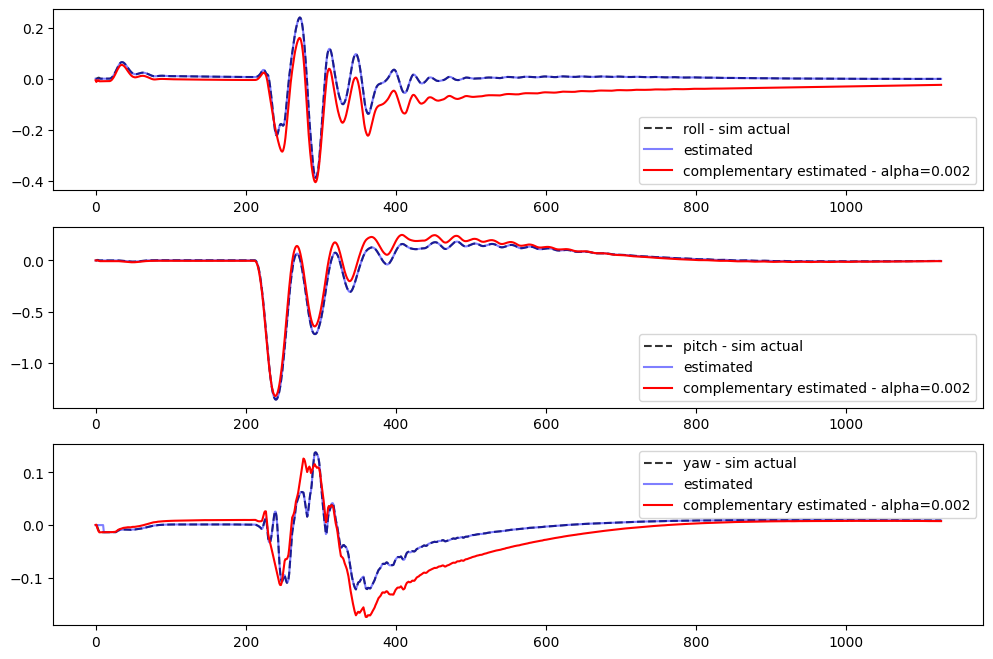

In [108]:
#print(ctx.keys())
for e in ctx.keys():
    pass
    #print(f"{e}: {len(ctx[e])}")
    
## Reconstruct
est_roll = []
est_pitch = []
est_yaw = []

## Simple filter
accel_x_prev = 0
accel_y_prev = 0
accel_z_prev = 0

#filt_alpha = 0.9
filt_alpha=0

alpha=0.002
for i in range(0,len(ctx['roll'])):
    accel_x_prev = filt_alpha*accel_x_prev + (1-filt_alpha)*ctx['accel_x'][i]
    accel_y_prev = filt_alpha*accel_y_prev + (1-filt_alpha)*ctx['accel_y'][i]
    accel_z_prev = filt_alpha*accel_z_prev + (1-filt_alpha)*ctx['accel_z'][i]
    
    m_roll = math.atan2(
        -accel_y_prev,
        -accel_z_prev
    )

    m_pitch = math.atan2(
        accel_x_prev,
        math.sqrt(accel_y_prev**2 + accel_z_prev**2)
    )

    ## Normalize mag reading
    mag_norm = math.sqrt(ctx['comp_x'][i]**2 + ctx['comp_y'][i]**2 + ctx['comp_z'][i]**2)
    ctx['comp_x'][i] /= (mag_norm if mag_norm!=0 else 1)
    ctx['comp_y'][i] /= (mag_norm if mag_norm!=0 else 1)
    ctx['comp_z'][i] /= (mag_norm if mag_norm!=0 else 1)

    ## Print accel norm
    acc_norm = math.sqrt(ctx['accel_x'][i]**2 + ctx['accel_y'][i]**2 + ctx['accel_z'][i]**2)
    
    m_yaw = math.atan2(
        -(ctx['comp_y'][i]*math.cos(m_roll) - ctx['comp_z'][i]*math.sin(m_roll)),
        ctx['comp_x'][i]*math.cos(m_pitch)+ctx['comp_y'][i]*math.sin(m_pitch)*math.sin(m_roll) + ctx['comp_z'][i]*math.sin(m_pitch)*math.cos(m_roll)
    )

    ## Correct for declination
    m_yaw += 0.19

    ## TODO NOTE Change to euler rates rather than gyro here (even though approx. same)
    g_roll = (est_roll[i-1] if i!=0 else 0) + 0.01*ctx['gyro_x'][i]
    g_pitch = (est_pitch[i-1] if i!=0 else 0) + 0.01*ctx['gyro_y'][i]
    g_yaw = (est_yaw[i-1] if i!=0 else 0) + 0.01*ctx['gyro_z'][i]

    est_roll.append(m_roll*alpha + g_roll*(1-alpha))
    est_pitch.append(m_pitch*alpha + g_pitch*(1-alpha))
    est_yaw.append(m_yaw*alpha + g_yaw*(1-alpha))
    
fig, ax = plt.subplots(3,1, figsize=(12,8))
ax[0].plot(range(0,len(ctx['eul_x_a'])), ctx['eul_x_a'], color='black', linestyle='--', alpha=0.8, label='roll - sim actual')
ax[0].plot(range(0,len(ctx['roll'])), ctx['roll'], color='blue', alpha=0.5, label='estimated')
ax[0].plot(range(0,len(est_roll)), est_roll, color='red', label=f'complementary estimated - alpha={alpha}')
#ax[0].set_ylim(-0.1, 0.1)
ax[0].legend()

ax[1].plot(range(0,len(ctx['eul_y_a'])), ctx['eul_y_a'], color='black', linestyle='--', alpha=0.8, label='pitch - sim actual')
ax[1].plot(range(0,len(ctx['pitch'])), ctx['pitch'], color='blue', alpha=0.5, label='estimated')
ax[1].plot(range(0,len(est_pitch)), est_pitch, color='red', label=f'complementary estimated - alpha={alpha}')
ax[1].legend()

ax[2].plot(range(0,len(ctx['eul_z_a'])), ctx['eul_z_a'], color='black', linestyle='--', alpha=0.8, label='yaw - sim actual')
ax[2].plot(range(0,len(ctx['yaw'])), ctx['yaw'], color='blue', alpha=0.5, label='estimated')
ax[2].plot(range(0,len(est_yaw)), est_yaw, color='red', label=f'complementary estimated - alpha={alpha}')
ax[2].legend()

plt.show()

## EKF with simulation sensor readings
TODO add equations

In [112]:
import numpy as np
import casadi as ca
import math
from scipy.spatial.transform import Rotation as R

''' Extended Kalman Filter w 10-state (3-pos, 3-vel, att quaternion) but no sensor bias states'''

def skew(v):
    '''Returns a skew-symmetric of a matrix'''
    return ca.vertcat(
        ca.horzcat(0, -v[2], v[1]),
        ca.horzcat(v[2], 0, -v[0]),
        ca.horzcat(-v[1], v[0], 0))

def to_rotation(q):
    return ca.vertcat(
        ca.horzcat(
            q[0]**2+q[1]**2-q[2]**2-q[3]**2,
            2*(q[1]*q[2]-q[0]*q[3]),
            2*(q[1]*q[3]+q[0]*q[2])),
        ca.horzcat(
            2*(q[1]*q[2]+q[0]*q[3]),
            q[0]*q[0]-q[1]*q[1]+q[2]*q[2]-q[3]*q[3],
            2*(q[2]*q[3]-q[0]*q[1])),
        ca.horzcat(
            2*(q[1]*q[3]-q[0]*q[2]),
            2*(q[0]*q[1]+q[2]*q[3]),
            q[0]*q[0]-q[1]*q[1]-q[2]*q[2]+q[3]*q[3]))

def setup_ins_ekf():
    ''' The returned EKF requires parameters in the following format/units.

    q (4,1) - initial quaternion state estimate
    a_reading (3,1) - normalized accelerometer reading in ENU frame (stationary g vector would be [0 0 g])
    m_reading (3,1) - normalized magnetometer reading in ENU frame
    g_reading (3,1) - gyrometer reading in rad/s
    dt (1,1) - time elapsed since last reading/update
    gyro_var - gyrometer variance estimate
    accel_var - accelerometer variance estimate
    mag_var - magnetometer variance estimate

    '''

    ########################################
    ### 1. Prediction
    ########################################

    ## Symbolic variables - predict

    # Gyrometer reading and variance
    w = ca.SX.sym('w', 3, 1)
    gyro_var = ca.SX.sym('gvar')

    # Accelerometer reading
    a_reading = ca.SX.sym('a', 3, 1)
    accel_var = ca.SX.sym('avar')

    # Timestep
    dt = ca.SX.sym('dt')

    # Initial quaternion
    q = ca.SX.sym('q', 4, 1)
    p = ca.SX.sym('p', 10, 10)

    ## Position and velocity states
    x = ca.SX.sym('x', 3, 1)
    v = ca.SX.sym('v', 3, 1)

    # Calculate omega vec for attitude quaternion
    omega = ca.vertcat(
        ca.horzcat(0, -w.T),
        ca.horzcat(w, -skew(w)))

    # Calculate rotation matrix
    C_rot = to_rotation(q)

    # Calculate gravitational reference vector
    g_ref = ca.vertcat(0,0,1)

    # State prediction using gyro and accelerometer readings
    state_f = ca.vertcat(
            x + v*dt,
            v + (C_rot.T @ a_reading - g_ref)*dt,
            (ca.SX_eye(4)+(dt/2)*omega) @ q
            )
    
    # 10-state matrix
    state_vec = ca.vertcat(x,v,q)

    ## Compute state jacobian
    state_jac = ca.jacobian(state_f, state_vec)
    if False:
        print(state_jac)

    ## State noise matrix
    xi_k = ca.vertcat(
            -(q[1:4]).T,
            q[0]*ca.SX_eye(3) + skew(q[1:4])
            )

    gy_noise = (-dt/2)*(xi_k @ ca.vertcat(ca.sqrt(gyro_var), ca.sqrt(gyro_var), ca.sqrt(gyro_var)) )
    noise_q = gy_noise @ gy_noise.T
    process_noise = ca.vertcat(
            ca.horzcat(accel_var*(dt**4)*ca.SX_eye(3), ca.SX.zeros(3,3), ca.SX.zeros(3,4)),
            ca.horzcat(ca.SX.zeros(3,3), accel_var*(dt**2)*ca.SX_eye(3), ca.SX.zeros(3,4)),
            ca.horzcat(ca.SX.zeros(4,3), ca.SX.zeros(4,3), noise_q)
            )

    # Estimation process covariance
    p_est = state_jac @ p @ state_jac.T + process_noise

    ''' Predict function

    Arguments:
        - dt : timestep in seconds since last predict call
        - w : gyrometer reading
        - a_reading : accelerometer reading
        - gyro_var : gyrometer noise
        - accel_var : accelerometer noise
        - p : covariance matrix
        - q : attitude quaternion (state)
        - x : position (state)
        - v : velocity (state)

    Returns:
        - state_f : Estimate of state
        - p_est   : Estimate of covariance matrix
    '''
    ekf_predict = ca.Function('ekf_predict', [dt, w, a_reading, gyro_var, accel_var, p, q, x, v], [state_f, p_est])

    ########################################
    ## 2. Correction
    ########################################

    ## Symbolic variables for correction step

    # Predicted state vector (output from predict step, (x,v,q) )
    state_est = ca.SX.sym('state_estimate', 10, 1)
    
    # Predicted covariance vector (output from predict step)
    cov_est = ca.SX.sym('covariance_estimate', 10, 10)

    # Magnetometer reading and variance
    m_reading = ca.SX.sym('m', 3, 1)
    mag_var = ca.SX.sym('mvar')

    # GPS Position reading and variance
    gps_pos = ca.SX.sym('gps_x', 3, 1)
    gps_pos_var = ca.SX.sym('gps_xvar')

    # GPS Velocity reading and variance
    gps_vel = ca.SX.sym('gps_v', 3, 1)
    gps_vel_var = ca.SX.sym('gps_vvar')

    ### Magnetic field reference vector

    # Our magnetic field is in ENU frame. 
    # We use 68deg as our magnetic field inclination
    _m1 = np.cos(68*np.pi/180)
    _m2 = np.sin(68*np.pi/180)
    _norm = np.linalg.norm([_m1, _m2])
    m_ref = ca.vertcat(0, _m1, _m2) / _norm

    # Compute rotation again
    est_C_rot = to_rotation(state_est[6:10])

    ### Measurement matrix (estimated reference vectors in sensor frame)
    measurement = ca.vertcat(est_C_rot.T @ g_ref,
                             est_C_rot.T @ m_ref,
                             state_est[0:3], # position
                             state_est[3:6]) # velocity

    ## Measurement jacobian (wrt state)
    measurement_jacobian = ca.jacobian(measurement, state_est)

    ## Measurement noise
    m_noise = ca.vertcat(
        ca.horzcat(accel_var*ca.SX_eye(3), ca.SX.zeros(3,9)),
        ca.horzcat(ca.SX.zeros(3,3), mag_var*ca.SX_eye(3), ca.SX.zeros(3,6)),
        ca.horzcat(ca.SX.zeros(3,6), gps_pos_var*ca.SX_eye(3), ca.SX.zeros(3,3)),
        ca.horzcat(ca.SX.zeros(3,9), gps_vel_var*ca.SX_eye(3))
        )

    ### Error between reference vector estimates (in sensor frame) and actual sensor readings
    vt = ca.vertcat(a_reading,
                    m_reading,
                    gps_pos,
                    gps_vel) - measurement

    ### Compute Kalman gain
    st = measurement_jacobian @ cov_est @ measurement_jacobian.T + m_noise
    kalman_gain = cov_est @ measurement_jacobian.T @ ca.inv(st)

    ### Apply the Kalman gain to estimate the (corrected) state
    state_out = state_est + kalman_gain @ vt
    p_out = cov_est - kalman_gain @ measurement_jacobian @ cov_est

    ''' Correct step

    Arguments:
        - state_est : Estimated state from the predict step
        - cov_est   : Estimated covariance matrix from the predict step
        - a_reading : Accelerometer reading
        - accel_var : Accelerometer noise
        - m_reading : Magnetometer reading
        - mag_var   : Magnetometer noise
        - gps_pos   : GPS Position measurement
        - gps_vel   : GPS Velocity measurement
        - gps_pos_var : GPS position noise
        - gps_vel_var : GPS velocity noise

    Returns:
        - state_out   : Corrected state estimate
        - p_out       : Corrected covariance esetimate
        - vt          : Error term in state update
        - kalman_gain : Kalman gain applied to error term
    '''
    ekf_correct = ca.Function('ekf_correct',
                      [state_est, cov_est, a_reading, accel_var, m_reading, mag_var, gps_pos, gps_vel, gps_pos_var, gps_vel_var],
                      [state_out, p_out, vt, kalman_gain]
                      )

    return (ekf_predict, ekf_correct)

In [122]:
import time
import csv
import numpy as np

from scipy.spatial.transform import Rotation as R
from ahrs.common.orientation import acc2q
from ahrs import Quaternion

roll_est = []
pitch_est = []
yaw_est = []

if __name__=="__main__":

    ## Initialise EKF
    ekf_predict, ekf_correct = setup_ins_ekf()
    q_next = None
    x_next = np.array([0,0,0], dtype=np.float64).reshape((3,))
    v_next = np.array([0,0,0], dtype=np.float64).reshape((3,))
    p_next = np.eye(10)
    
    for i in range(0,len(ctx['roll'])):
        
        ## 1. Normalise accelerometer data
        _a_norm = math.sqrt(ctx['accel_x'][i]**2 + ctx['accel_y'][i]**2 + ctx['accel_z'][i]**2)
        ctx['accel_x'][i] /= ( _a_norm if _a_norm!=0 else 1)
        ctx['accel_y'][i] /= ( _a_norm if _a_norm!=0 else 1)
        ctx['accel_z'][i] /= ( _a_norm if _a_norm!=0 else 1)
        
        ## 2. Offset magnetometer data
        # NOTE Don't need for simulated data + should already be done in dev/AP_Compass class
        
        ## 4. Normalise magnetometer data
        _m_norm = math.sqrt(ctx['comp_x'][i]**2 + ctx['comp_y'][i]**2 + ctx['comp_z'][i]**2)
        ctx['comp_x'][i] /= (_m_norm if _m_norm!=0 else 1)
        ctx['comp_y'][i] /= (_m_norm if _m_norm!=0 else 1)
        ctx['comp_z'][i] /= (_m_norm if _m_norm!=0 else 1)

        ## Do rotations, if needed
        ## NOTE We don't for simulated readings
        
        ## NOTE We are not yet reading GPS measurements so for now just zero-init and have high var for GPS readings so minimal GPS correction
        ## 8. Reading GPS position and velocity vectors
        gps_pos = np.array([0,0,0], dtype=np.float64).reshape(3,1)
        gps_vel = np.array([0,0,0], dtype=np.float64).reshape(3,1)

        gps_pvar = 0.1
        gps_vvar = 0.1

        if q_next is None:
            q_next = acc2q([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]])

        ## Run the full EKF update
        if True:
            ## Predict
            state_est, cov_est = ekf_predict(
                    0.01,
                    np.array([ctx['gyro_x'][i], ctx['gyro_y'][i], ctx['gyro_z'][i]]),
                    np.array([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]]),
                    0.3**2, ## Gyro var
                    0.5**2, ## Accel var
                    p_next,
                    q_next,
                    x_next,
                    v_next)

            ## Correct
            state_out, cov_out, vt, kgain = ekf_correct(
                    state_est,
                    cov_est,
                    np.array([ctx['accel_x'][i], ctx['accel_y'][i], ctx['accel_z'][i]]),
                    0.5**2,
                    np.array([ctx['comp_x'][i], ctx['comp_y'][i], ctx['comp_z'][i]]),
                    0.8**2, ## Mag var
                    gps_pos,
                    gps_vel,
                    gps_pvar,
                    gps_vvar)

            ## Extract actual states from state vector
            state = state_out.full()

            ## NOTE State vector is in (x,v,q) format
            x_next = state_out[0:3].full()
            v_next = state_out[3:6].full()
            q_next = state_out[6:10].full()

        ''' FUNCTION SIGNATURES
        ekf_predict = ca.Function('ekf_predict',
            [dt, w, a_reading, gyro_var, accel_var, p, q, x, v],
            [state_f, p_est])

        ekf_correct = ca.Function('ekf',
            [state_est, cov_est, a_reading, accel_var, m_reading, mag_var, gps_pos, gps_vel, gps_pos_var, gps_vel_var],
            [state_out, p_out, vt, kalman_gain])
        '''

        ## Normalise output quaternion
        _q_norm = np.linalg.norm(q_next)
        q_next = q_next / _q_norm

        temp_eul = Quaternion(q_next.reshape(-1)).to_angles()
        roll_est.append(temp_eul[0])
        pitch_est.append(temp_eul[1])
        yaw_est.append(temp_eul[2])
        

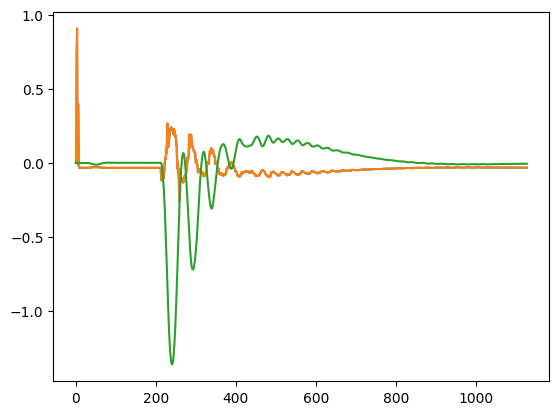

In [128]:
#plt.plot(range(0,len(roll_est)), roll_est)
plt.plot(range(0,len(pitch_est)), pitch_est)
plt.plot(range(0,len(pitch_est)), pitch_est)
#plt.plot(range(0,len(ctx['pitch'])), ctx['pitch'])
plt.plot(range(0,len(ctx['eul_y_a'])), ctx['eul_y_a'])